In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

#to make a random SPD matrix
from sklearn.datasets import make_spd_matrix

%matplotlib inline

In [7]:
def solveJacobi(P, r):
    
    """
    A function that returns the solution to the equation Pz_(k+1) = r_(k+1)
    when P is the Jacobi preconditioner (a diagonal matrix)
    
    Inputs:
        P : Jacobi preconditioner (Diagonal n x n matrix)
        r : residual at the current step (b - Ax)
    Returns:
        z : desired solution to the equation
    """
    
    invP = np.diag(np.reciprocal(P))
    z = invP @ r
    
    return z


def solveSGS(C, r):
    """
    A function that returns the solution to the equation Pz_(k+1) = r_(k+1)
    when P is the symmetric Gauss-Seidel preconditioner (D-E)D^{-1}(D-E^T) = CC^T
    
    Inputs:
        P : symmetric Gauss-Seidel preconditioner (CC^T)
        r : residual at the current step (b - Ax)
    Returns:
        z : desired solution to the equation
    """
    
    def forwardSub(L, b):
        '''solve the problem Ly = b'''
        n = b.shape[0]
        y = np.empty(n)
        y[0] = b[0] / L[0][0]
        
        #loop through the remaining entries
        for i in range(1, n):
            y[i] = (b[i] - L[i][0:i].dot(y[:i])) / L[i][i]
        return y
    
    def backwardSub(U, y):
        '''solve the problem Ux = y'''
        n = y.shape[0]
        x = np.empty(n)
        x[n-1] = y[n-1] / U[n-1][n-1]
        for i in reversed(range(n-1)):
            x[i] = (y[i] - U[i,i+1:].dot(x[i+1:])) / U[i][i]
        return x
    
    y = forwardSub(C, r)
    z = backwardSub(C.T, y)
    
    return z

In [8]:
def noPrecon(r):
    return r

def jacobiPrecon(A, r):
    #C = np.diag(np.sqrt(A))
    #P = C @ C.T
    z = solveJacobi(np.diag(A), r)
    return z

def sgsPrecon(A, r):
    diags = np.diag(A)
    C = np.tril(A)
    for i in range(A.shape[0]):
        C[:, i] = C[:, i] / np.sqrt(diags[i])
    z = solveSGS(C, r)
    return z

def getZFromPrecon(num, A, r):
    switch = {
        1: noPrecon(r),
        2: jacobiPrecon(A, r),
        3: sgsPrecon(A, r)
    }
    return switch.get(num, "Chose one of the following: 1, 2, or 3")

In [9]:
def PSD(A, b, preconType = 1, knownSol = None, desiredAcc = 10e-6):
        
    n = A.shape[0]
    x = np.random.rand(n,) #x0
    r = b - A @ x #r0
    
    #array to store relative error 
    relErr = []
    
    #if a known solution is provided, use that to compute relative error
    if knownSol is not None:
        acc = np.linalg.norm(x - knownSol) / np.linalg.norm(knownSol)
    else:
        acc = np.linalg.norm(r) / np.linalg.norm(b) #if no known solution given
            
    #record the first accuracy calculation in an array for future plotting
    relErr.append(acc)
    
    z = getZFromPrecon(preconType, A, r)
    
    #iterate through the algorithm until we reach desired accuracy
    while acc > desiredAcc:
        w = A @ z
        alpha = (z.T @ r) / (z.T @ w)
        x = x + alpha * z
        r = r - alpha * w
        z = getZFromPrecon(preconType, A, r)
        #if a known solution is provided, use that to compute relative error
        if knownSol is not None:
            acc = np.linalg.norm(x - knownSol) / np.linalg.norm(knownSol)
        else:
            acc = np.linalg.norm(r) / np.linalg.norm(b) #if no known solution given
        relErr.append(acc)
        
    return x, relErr


def PCG(A, b, preconType = 1, knownSol = None, desiredAcc = 10e-6):
    
    n = A.shape[0]
    x = np.random.randint(2, size = (n,)) #x0
    r = b - A @ x #r0
    
    #array to store relative error 
    relErr = []
    
    #if a known solution is provided, use that to compute relative error
    if knownSol is not None:
        acc = np.linalg.norm(x - knownSol) / np.linalg.norm(knownSol)
    else:
        acc = np.linalg.norm(r) / np.linalg.norm(b) #if no known solution given
            
    #record the first accuracy calculation in an array for future plotting
    relErr.append(acc)
    
    z = getZFromPrecon(preconType, A, r)
    p = z
    
    #iterate through the algorithm until we reach desired accuracy
    while acc > desiredAcc:
        
        #store the previous iterations for beta
        tempR = r 
        tempZ = z
        
        v = A @ p
        alpha = (r.T @ z) / (p.T @ v)
        x = x + alpha * p
        r = r - alpha * v
        z = getZFromPrecon(preconType, A, r)
        
        #if a known solution is provided, use that to compute relative error
        if knownSol is not None:
            acc = np.linalg.norm(x - knownSol) / np.linalg.norm(knownSol)
        else:
            acc = np.linalg.norm(r) / np.linalg.norm(b) #if no known solution given
        relErr.append(acc)
        
        beta = (r.T @ z) / (tempR.T @ tempZ)
        p = z + beta * p
        
    return x, relErr

In [10]:
eps = np.finfo(float).eps #smallest value possible in float for later calculations

#Testing with a known system
A = np.array([[3., 0], [0, 1.]])
b = np.array([2., 2.])
x = np.array([2/3, 2])

#no preconditioner
PSD2_none = PSD(A, b, knownSol = x)
PCG2_none = PCG(A, b, knownSol = x)

#preconditioner is Jacobi's conditioner
PSD2_Jacobi = PSD(A, b, preconType=2, knownSol = x)
PCG2_Jacobi = PCG(A, b, preconType=2, knownSol = x)

#preconditioner is SGS preconditioner
PSD2_SGS = PSD(A, b, preconType=3, knownSol = x)
PCG2_SGS = PCG(A, b, preconType=3, knownSol = x)

In [11]:
#Testing with a random 10x10 SPD matrix from nonsingular lower triangular
randA = np.random.randint(1, 3, size=(10,10))
randL = np.tril(randA)
randA = randL @ randL.T
randA = randA.astype(float)
randb = np.random.randint(20,30, size=(10,))

#no preconditioner on matrix
PSDrand_none = PSD(randA, randb)
PCGrand_none = PCG(randA, randb)

#preconditioner is Jacobi's conditioner
PSDrand_Jacobi = PSD(randA, randb, preconType=2)
PCGrand_Jacobi = PCG(randA, randb, preconType=2)

#preconditioner is SGS preconditioner
PSDrand_SGS = PSD(randA, randb, preconType=3)
PCGrand_SGS = PCG(randA, randb, preconType=3)

In [12]:
#Testing with a random 10x10 SPD from library
SPD10 = make_spd_matrix(n_dim = 10)
b10 = np.random.randint(5, size=(10, ))

#no preconditioner on matrix
PSD10_none = PSD(SPD10, b10)
PCG10_none = PCG(SPD10, b10)

#preconditioner is Jacobi's conditioner
PSD10_Jacobi = PSD(SPD10, b10, preconType=2)
PCG10_Jacobi = PCG(SPD10, b10, preconType=2)

#preconditioner is SGS preconditioner
PSD10_SGS = PSD(SPD10, b10, preconType=3)
PCG10_SGS = PCG(SPD10, b10, preconType=3)

In [13]:
#Testing with a random 100x100 SPD from library
SPD100 = make_spd_matrix(n_dim = 100)
b100 = np.random.randint(5, size=(100, ))

#no preconditioner on matrix
PSD100_none = PSD(SPD100, b100)
PCG100_none = PCG(SPD100, b100)

#preconditioner is Jacobi's conditioner
PSD100_Jacobi = PSD(SPD100, b100, preconType=2)
PCG100_Jacobi = PCG(SPD100, b100, preconType=2)

#preconditioner is SGS preconditioner
PSD100_SGS = PSD(SPD100, b100, preconType=3)
PCG100_SGS = PCG(SPD100, b100, preconType=3)

In [14]:
#Task 2: Correctness test
Atest = np.array([[5, 7, 6, 5], [7, 10, 8, 7], [6, 8, 10, 9], [5, 7, 9, 10]], float)
btest = np.array([23, 32, 33, 31], float)

PSDTest_none = PSD(Atest, btest)
PCGTest_none = PCG(Atest, btest)
PSDTest_Jacobi = PSD(Atest, btest, preconType=2)
PCGTest_Jacobi = PCG(Atest, btest, preconType=2)
PSDTest_SGS = PSD(Atest, btest, preconType=3)
PCGTest_SGS = PCG(Atest, btest, preconType=3)

In [15]:
#Save iteration counts per method per matrix to text file
data = '..\\data\\'

#Preconditioned Stochastic Descent iteration numbers
k_PSD2_none = "k_{I} = " + str(len(PSD2_none[1]) - 1)
k_PSD2_Jacobi = "k_{Jacobi} = " + str(len(PSD2_Jacobi[1]) - 1)
k_PSD2_SGS = "k_{SGS} = " + str(len(PSD2_SGS[1]) - 1)

#save iteration counts to text file
np.savetxt(os.path.join(data, '2x2 PSD Iteration Counts.txt'),  (k_PSD2_none, k_PSD2_Jacobi, k_PSD2_SGS), '%s')

k_PSDrand_none = "k_{I} = " + str(len(PSDrand_none[1]) - 1)
k_PSDrand_Jacobi = "k_{Jacobi} = " + str(len(PSDrand_Jacobi[1]) - 1)
k_PSDrand_SGS = "k_{SGS} = " + str(len(PSDrand_SGS[1]) - 1)

#save iteration counts to text file
np.savetxt(os.path.join(data, '4x4 PSD Iteration Counts.txt'),  (k_PSDrand_none, k_PSDrand_Jacobi, k_PSDrand_SGS), '%s')

k_PSD10_none = "k_{I} = " + str(len(PSD10_none[1]) - 1)
k_PSD10_Jacobi = "k_{Jacobi} = " + str(len(PSD10_Jacobi[1]) - 1)
k_PSD10_SGS = "k_{SGS} = " + str(len(PSD10_SGS[1]) - 1)

np.savetxt(os.path.join(data, '10x10 PSD Iteration Counts.txt'),  (k_PSD10_none, k_PSD10_Jacobi, k_PSD10_SGS), '%s')

k_PSD100_none = "k_{I} = " + str(len(PSD100_none[1]) - 1)
k_PSD100_Jacobi = "k_{Jacobi} = " + str(len(PSD100_Jacobi[1]) - 1)
k_PSD100_SGS = "k_{SGS} = " + str(len(PSD100_SGS[1]) - 1)

#save iteration counts to text file
np.savetxt(os.path.join(data, '100x100 PSD Iteration Counts.txt'),  (k_PSD100_none, k_PSD100_Jacobi, k_PSD100_SGS), '%s')

k_PSDTest_none = "k_{I} = " + str(len(PSDTest_none[1]) - 1)
k_PSDTest_Jacobi = "k_{Jacobi} = " + str(len(PSDTest_Jacobi[1]) - 1)
k_PSDTest_SGS = "k_{SGS} = " + str(len(PSDTest_SGS[1]) - 1)

#save iteration counts to text file
np.savetxt(os.path.join(data, '10x10 L1 PSD Iteration Counts.txt'),  (k_PSDTest_none, k_PSDTest_Jacobi, k_PSDTest_SGS), '%s')



#Preconditioned Conjugate Gradient iteration numbers
k_PCG2_none = "k_{I} = " + str(len(PCG2_none[1]) - 1)
k_PCG2_Jacobi = "k_{Jacobi} = " + str(len(PCG2_Jacobi[1]) - 1)
k_PCG2_SGS = "k_{SGS} = " + str(len(PCG2_SGS[1]) - 1)

#save iteration counts to text file
np.savetxt(os.path.join(data, '2x2 PCG Iteration Counts.txt'),  (k_PCG2_none, k_PCG2_Jacobi, k_PCG2_SGS), '%s')

k_PCGrand_none = "k_{I} = " + str(len(PCGrand_none[1]) - 1)
k_PCGrand_Jacobi = "k_{Jacobi} = " + str(len(PCGrand_Jacobi[1]) - 1)
k_PCGrand_SGS = "k_{SGS} = " + str(len(PCGrand_SGS[1]) - 1)

#save iteration counts to text file
np.savetxt(os.path.join(data, '4x4 PCG Iteration Counts.txt'),  (k_PCGrand_none, k_PCGrand_Jacobi, k_PCGrand_SGS), '%s')

k_PCG10_none = "k_{I} = " + str(len(PCG10_none[1]) - 1)
k_PCG10_Jacobi = "k_{Jacobi} = " + str(len(PCG10_Jacobi[1]) - 1)
k_PCG10_SGS = "k_{SGS} = " + str(len(PCG10_SGS[1]) - 1)

np.savetxt(os.path.join(data, '10x10 PCG Iteration Counts.txt'),  (k_PCG10_none, k_PCG10_Jacobi, k_PCG10_SGS), '%s')

k_PCG100_none = "k_{I} = " + str(len(PCG100_none[1]) - 1)
k_PCG100_Jacobi = "k_{Jacobi} = " + str(len(PCG100_Jacobi[1]) - 1)
k_PCG100_SGS = "k_{SGS} = " + str(len(PCG100_SGS[1]) - 1)

#save iteration counts to text file
np.savetxt(os.path.join(data, '100x100 PCG Iteration Counts.txt'),  (k_PCG100_none, k_PCG100_Jacobi, k_PCG100_SGS), '%s')

k_PCGTest_none = "k_{I} = " + str(len(PCGTest_none[1]) - 1)
k_PCGTest_Jacobi = "k_{Jacobi} = " + str(len(PCGTest_Jacobi[1]) - 1)
k_PCGTest_SGS = "k_{SGS} = " + str(len(PCGTest_SGS[1]) - 1)

#save iteration counts to text file
np.savetxt(os.path.join(data, '10x10 L1 PCG Iteration Counts.txt'),  (k_PCGTest_none, k_PCGTest_Jacobi, k_PCGTest_SGS), '%s')

# No Preconditioner Plots

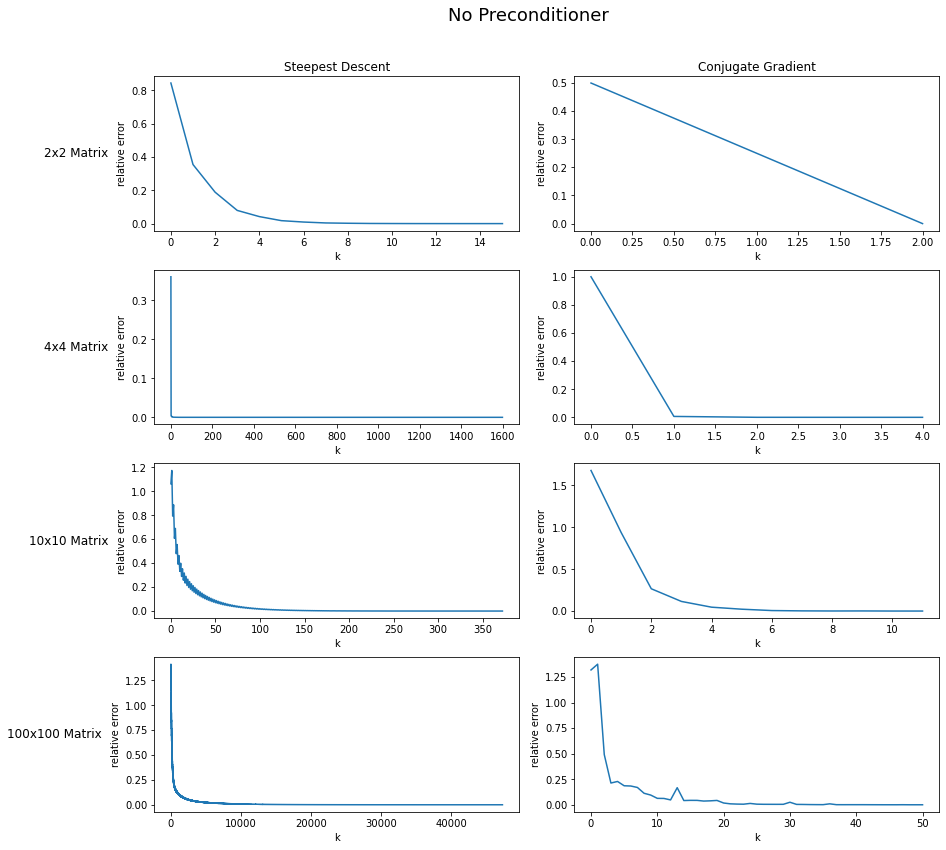

In [16]:
#NO PRECONDITIONER PLOTS

#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers

from matplotlib.transforms import offset_copy

cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['2x2 Matrix', '4x4 Matrix', '10x10 Matrix', '100x100 Matrix']]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 12))
plt.setp(axes.flat, xlabel='k', ylabel='relative error')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].plot(PSD2_none[1])
axes[1][0].plot(PSDTest_none[1])
axes[2][0].plot(PSD10_none[1])
axes[3][0].plot(PSD100_none[1])

#plot the conjugate gradient errors
axes[0][1].plot(PCG2_none[1])
axes[1][1].plot(PCGTest_none[1])
axes[2][1].plot(PCG10_none[1])
axes[3][1].plot(PCG100_none[1])


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("No Preconditioner", fontsize = 18, x = 0.55)

plt.savefig("..//figures/No Preconditioner")
plt.show()

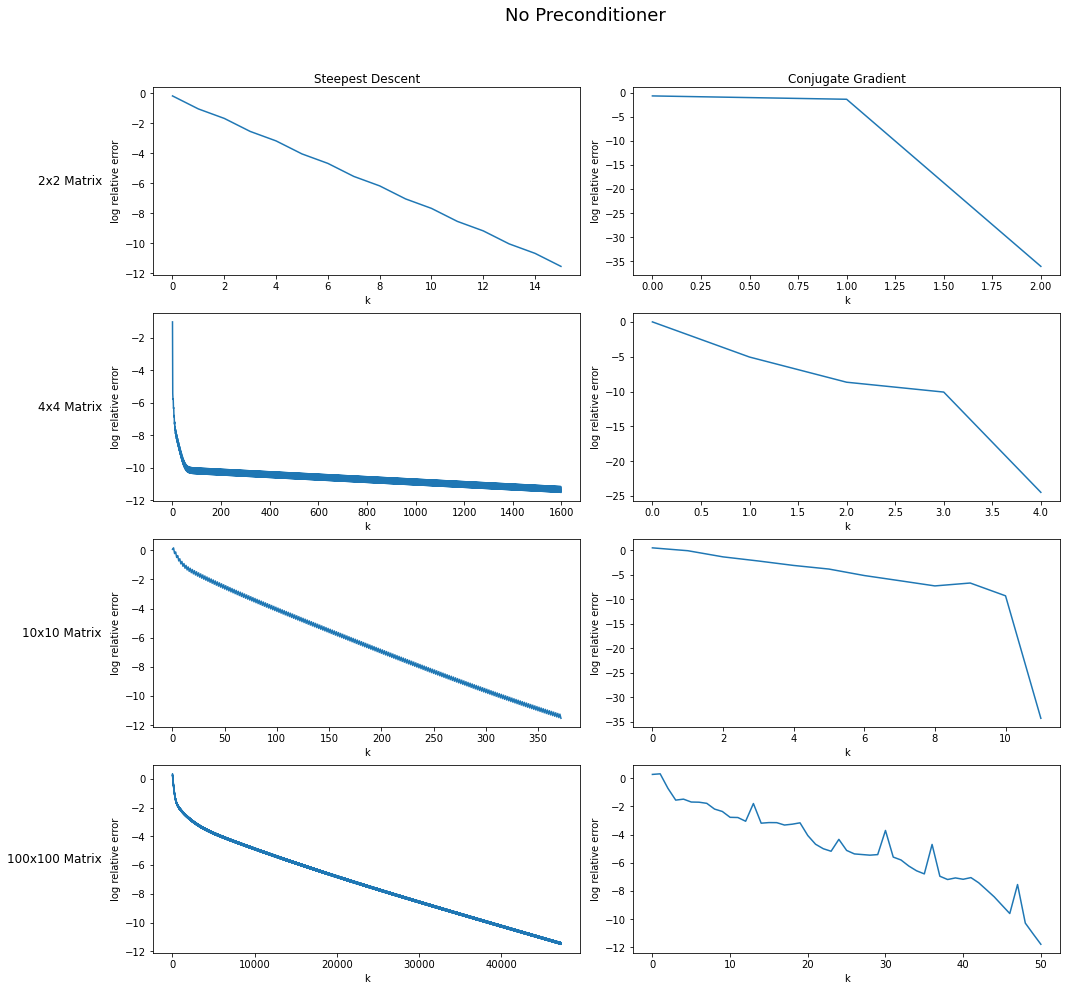

In [17]:
#NO PRECONDITIONER PLOTS

#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers

from matplotlib.transforms import offset_copy

cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['2x2 Matrix', '4x4 Matrix', '10x10 Matrix', '100x100 Matrix']]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 14))
plt.setp(axes.flat, xlabel='k', ylabel='log relative error')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].plot(np.log(PSD2_none[1] + eps))
axes[1][0].plot(np.log(PSDTest_none[1]))
axes[2][0].plot(np.log(PSD10_none[1]))
axes[3][0].plot(np.log(PSD100_none[1]))

#plot the conjugate gradient errors
axes[0][1].plot(np.log(PCG2_none[1] + eps))
axes[1][1].plot(np.log(PCGTest_none[1]))
axes[2][1].plot(np.log(PCG10_none[1]))
axes[3][1].plot(np.log(PCG100_none[1]))


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("No Preconditioner", fontsize = 18, x = 0.55)

plt.savefig("..//figures/Log No Preconditioner")
plt.show()

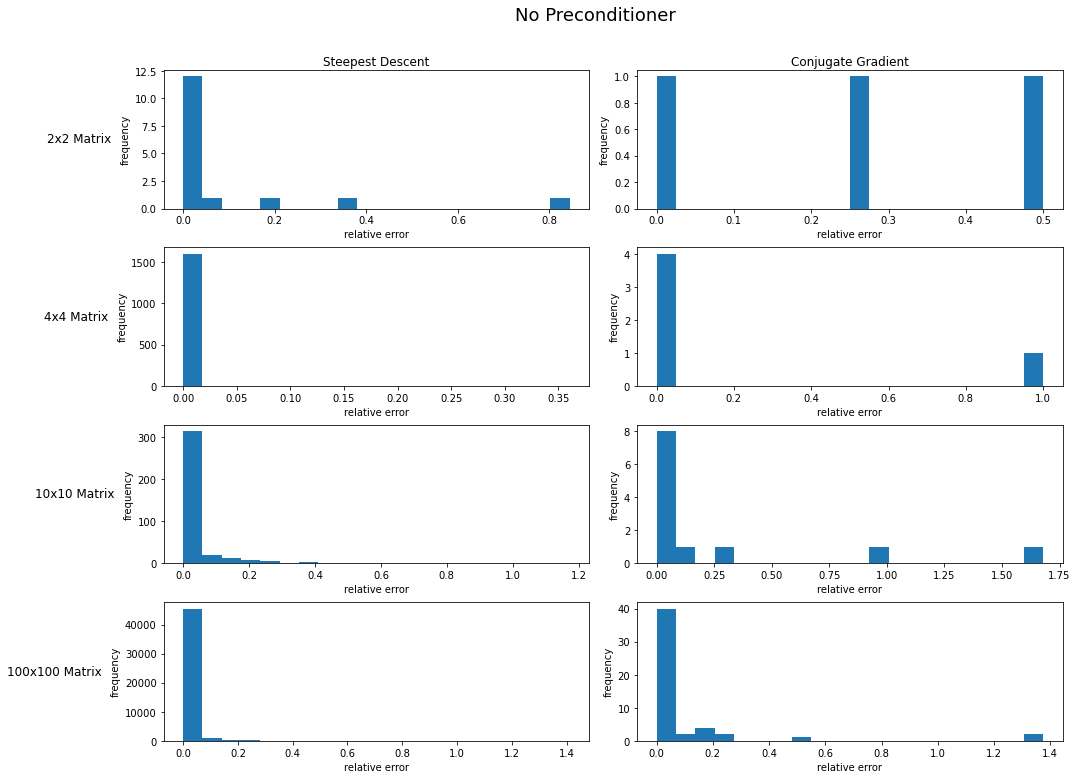

In [18]:
#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers

cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['2x2 Matrix', '4x4 Matrix', '10x10 Matrix', '100x100 Matrix']]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 11))
plt.setp(axes.flat, xlabel='relative error', ylabel='frequency')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].hist(PSD2_none[1], 20)
axes[1][0].hist(PSDTest_none[1], 20)
axes[2][0].hist(PSD10_none[1], 20)
axes[3][0].hist(PSD100_none[1], 20)

#plot the conjugate gradient errors
axes[0][1].hist(PCG2_none[1], 20)
axes[1][1].hist(PCGTest_none[1], 20)
axes[2][1].hist(PCG10_none[1], 20)
axes[3][1].hist(PCG100_none[1], 20)


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("No Preconditioner", fontsize = 18, x = 0.55)

plt.savefig("..//figures/No Preconditioner Histogram")
plt.show()

# Jacobi Preconditioner Plots

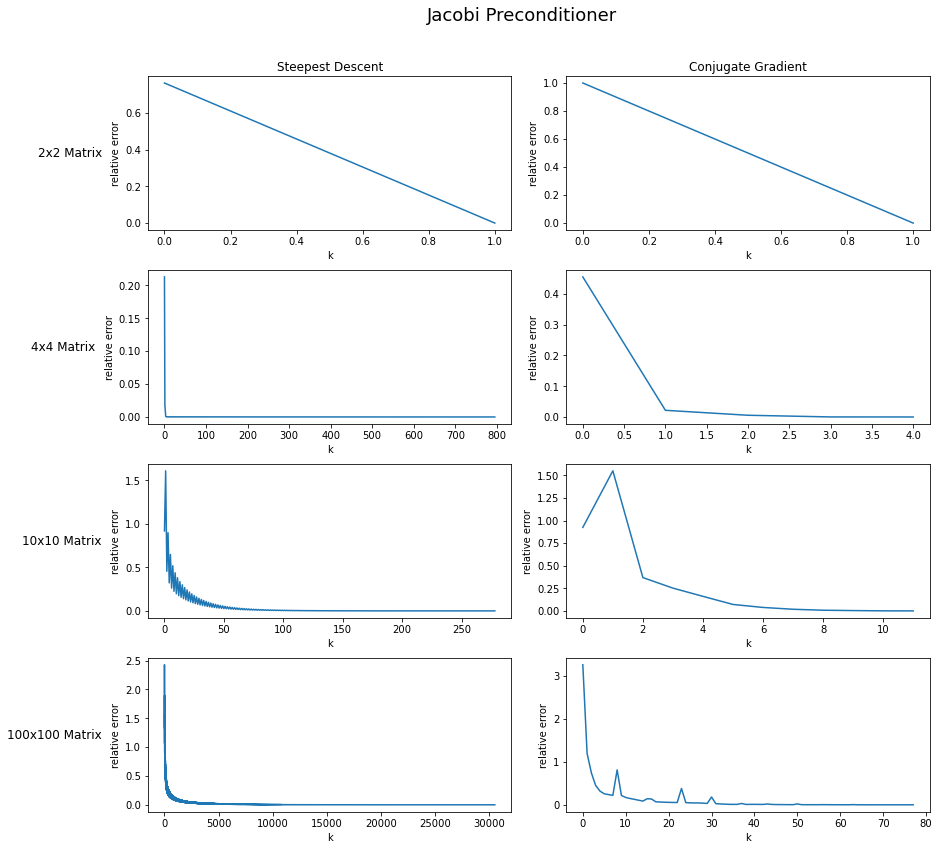

In [19]:
#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers
cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['2x2 Matrix', '4x4 Matrix', '10x10 Matrix', '100x100 Matrix']]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 12))
plt.setp(axes.flat, xlabel='k', ylabel='relative error')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].plot(PSD2_Jacobi[1])
axes[1][0].plot(PSDTest_Jacobi[1])
axes[2][0].plot(PSD10_Jacobi[1])
axes[3][0].plot(PSD100_Jacobi[1])

#plot the conjugate gradient errors
axes[0][1].plot(PCG2_Jacobi[1])
axes[1][1].plot(PCGTest_Jacobi[1])
axes[2][1].plot(PCG10_Jacobi[1])
axes[3][1].plot(PCG100_Jacobi[1])


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("Jacobi Preconditioner", fontsize = 18, x = 0.55)

plt.savefig("..//figures/Jacobi Preconditioner")
plt.show()

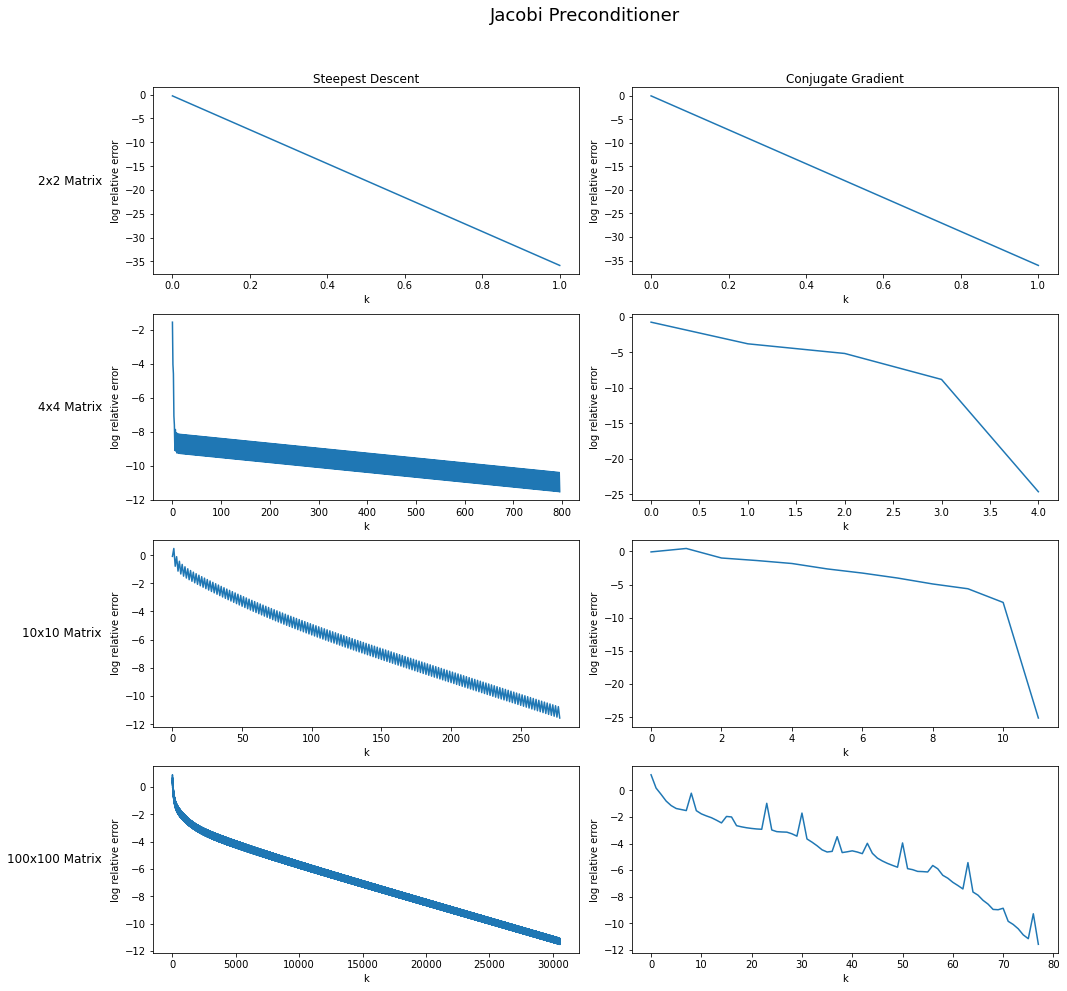

In [20]:
#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers
cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['2x2 Matrix', '4x4 Matrix', '10x10 Matrix', '100x100 Matrix']]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 14))
plt.setp(axes.flat, xlabel='k', ylabel='log relative error')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].plot(np.log(PSD2_Jacobi[1] + eps))
axes[1][0].plot(np.log(PSDTest_Jacobi[1] + eps))
axes[2][0].plot(np.log(PSD10_Jacobi[1]))
axes[3][0].plot(np.log(PSD100_Jacobi[1]))

#plot the conjugate gradient errors
axes[0][1].plot(np.log(PCG2_Jacobi[1] + eps))
axes[1][1].plot(np.log(PCGTest_Jacobi[1] + eps))
axes[2][1].plot(np.log(PCG10_Jacobi[1]))
axes[3][1].plot(np.log(PCG100_Jacobi[1]))


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("Jacobi Preconditioner", fontsize = 18, x = 0.55)

plt.savefig("..//figures/Log Jacobi Preconditioner")
plt.show()

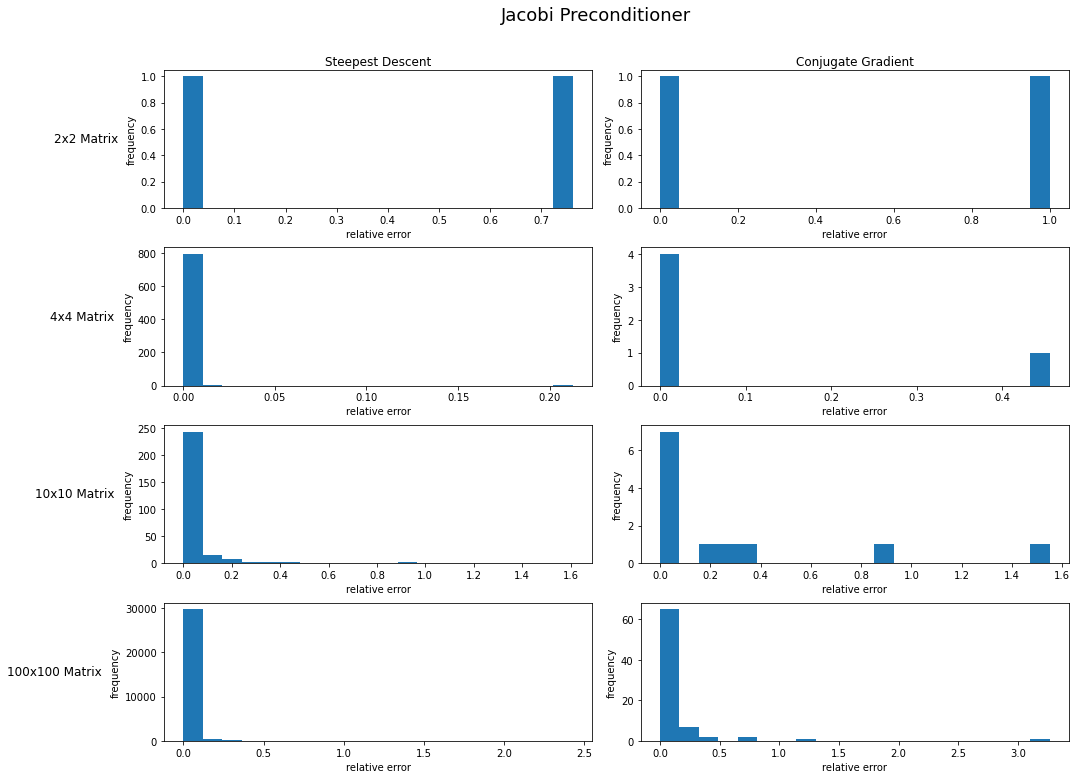

In [21]:
#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers
cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['2x2 Matrix', '4x4 Matrix', '10x10 Matrix', '100x100 Matrix']]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 11))
plt.setp(axes.flat, xlabel='relative error', ylabel='frequency')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].hist(PSD2_Jacobi[1], 20)
axes[1][0].hist(PSDTest_Jacobi[1], 20)
axes[2][0].hist(PSD10_Jacobi[1], 20)
axes[3][0].hist(PSD100_Jacobi[1], 20)

#plot the conjugate gradient errors
axes[0][1].hist(PCG2_Jacobi[1], 20)
axes[1][1].hist(PCGTest_Jacobi[1], 20)
axes[2][1].hist(PCG10_Jacobi[1], 20)
axes[3][1].hist(PCG100_Jacobi[1], 20)


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("Jacobi Preconditioner", fontsize = 18, x = 0.55)

plt.savefig("..//figures/Jacobi Preconditioner Histogram")
plt.show()

# Symmetric G-S Preconditioner Plots

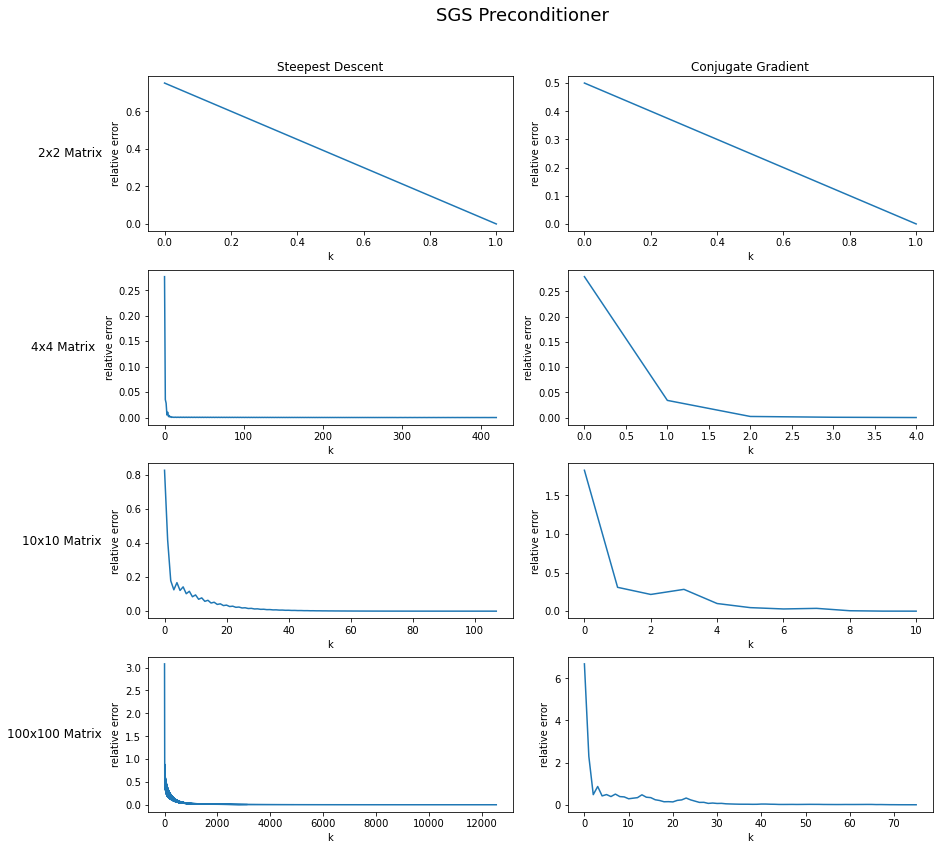

In [22]:
#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers

cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['2x2 Matrix', '4x4 Matrix', '10x10 Matrix', '100x100 Matrix']]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 12))
plt.setp(axes.flat, xlabel='k', ylabel='relative error')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].plot(PSD2_SGS[1])
axes[1][0].plot(PSDTest_SGS[1])
axes[2][0].plot(PSD10_SGS[1])
axes[3][0].plot(PSD100_SGS[1])

#plot the conjugate gradient errors
axes[0][1].plot(PCG2_SGS[1])
axes[1][1].plot(PCGTest_SGS[1])
axes[2][1].plot(PCG10_SGS[1])
axes[3][1].plot(PCG100_SGS[1])


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("SGS Preconditioner", fontsize = 18, x = 0.55)

plt.savefig("..//figures/SGS Preconditioner")
plt.show()

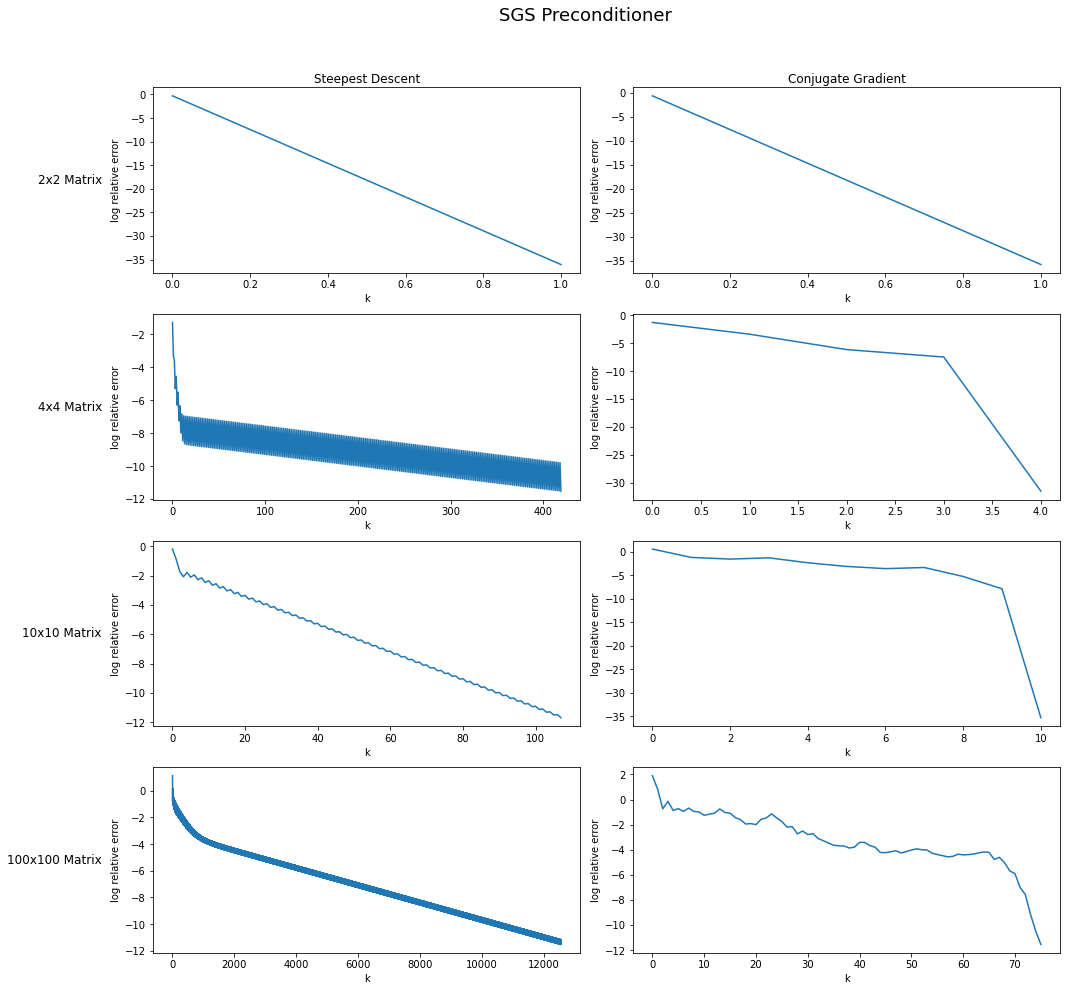

In [23]:
#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers

cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['2x2 Matrix', '4x4 Matrix', '10x10 Matrix', '100x100 Matrix']]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 14))
plt.setp(axes.flat, xlabel='k', ylabel='log relative error')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
#need to add absurdly small value if error goes to 0.0
axes[0][0].plot(np.log(PSD2_SGS[1] + eps)) 
axes[1][0].plot(np.log(PSDTest_SGS[1] + eps))
axes[2][0].plot(np.log(PSD10_SGS[1] + eps))
axes[3][0].plot(np.log(PSD100_SGS[1] + eps))

#plot the conjugate gradient errors
axes[0][1].plot(np.log(PCG2_SGS[1]+ eps)) #need to add absurdly small value since error goes to 0.0
axes[1][1].plot(np.log(PCGTest_SGS[1] + eps))
axes[2][1].plot(np.log(PCG10_SGS[1] + eps))
axes[3][1].plot(np.log(PCG100_SGS[1] + eps))


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("SGS Preconditioner", fontsize = 18, x = 0.55)

plt.savefig("..//figures/Log SGS Preconditioner")
plt.show()

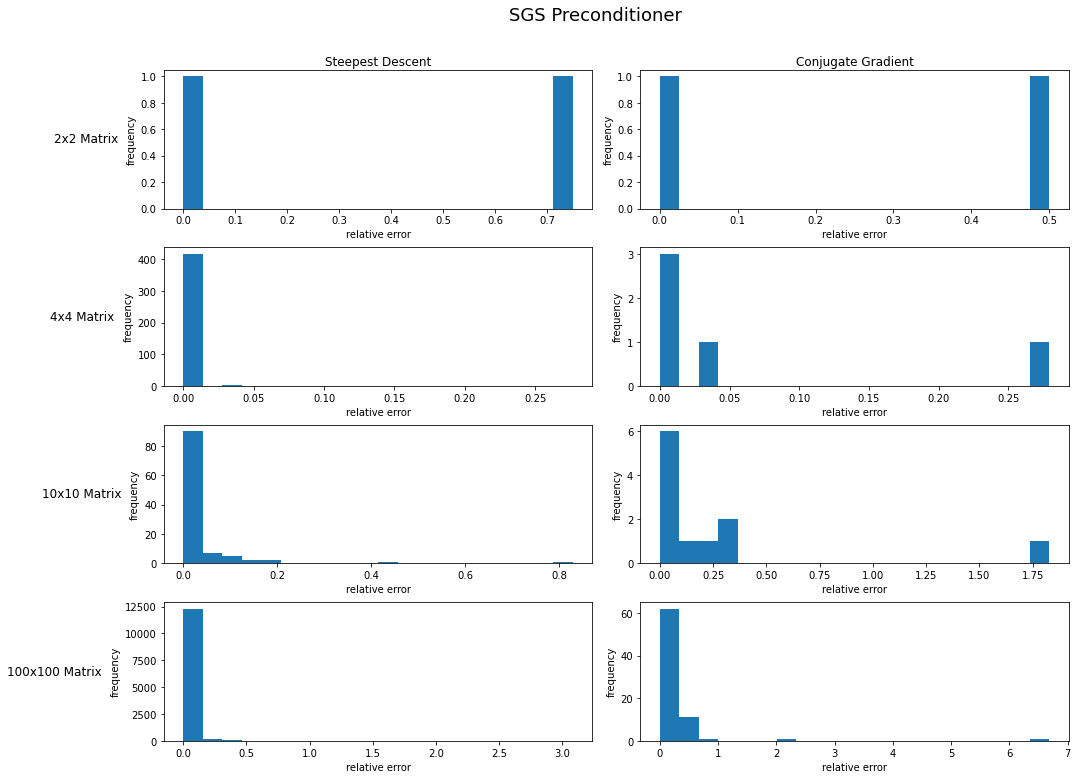

In [24]:
#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers

cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['2x2 Matrix', '4x4 Matrix', '10x10 Matrix', '100x100 Matrix']]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 11))
plt.setp(axes.flat, xlabel='relative error', ylabel='frequency')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].hist(PSD2_SGS[1], 20)
axes[1][0].hist(PSDTest_SGS[1], 20)
axes[2][0].hist(PSD10_SGS[1], 20)
axes[3][0].hist(PSD100_SGS[1], 20)

#plot the conjugate gradient errors
axes[0][1].hist(PCG2_SGS[1], 20)
axes[1][1].hist(PCGTest_SGS[1], 20)
axes[2][1].hist(PCG10_SGS[1], 20)
axes[3][1].hist(PCG100_SGS[1], 20)


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("SGS Preconditioner", fontsize = 18, x = 0.55)

plt.savefig("..//figures/SGS Preconditioner Histogram")
plt.show()

# SPD From Lower Triangular Matrix $L_1$

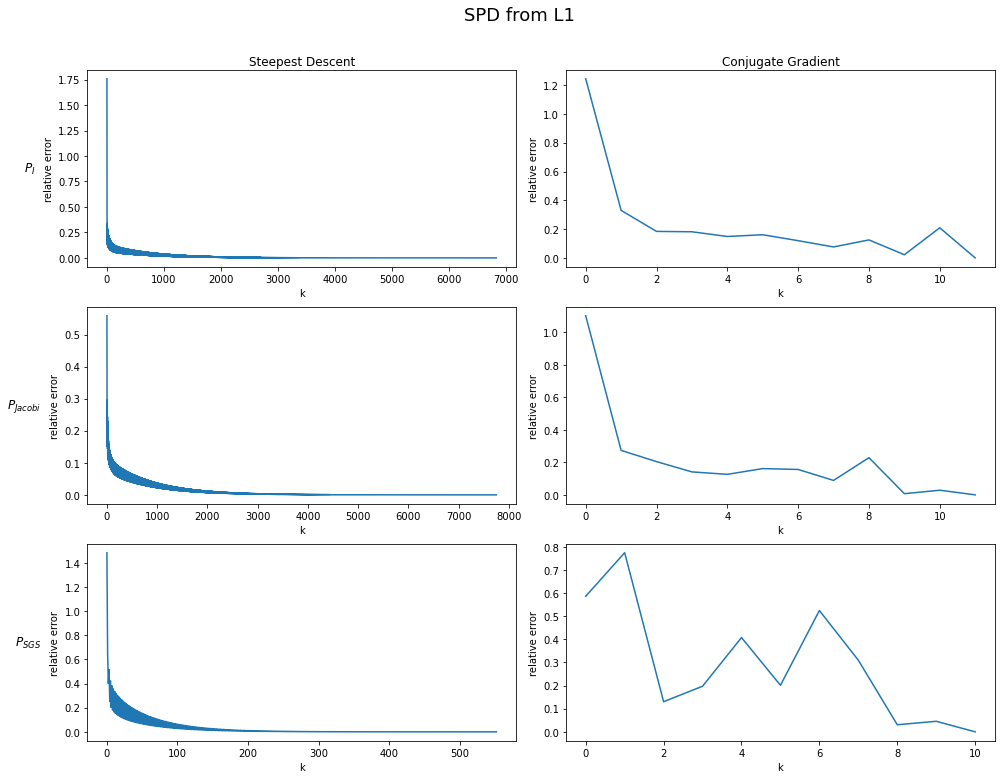

In [25]:
#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers

cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['$P_{I}$', '$P_{Jacobi}$', '$P_{SGS}$']]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 11))
plt.setp(axes.flat, xlabel='k', ylabel='relative error')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].plot(PSDrand_none[1])
axes[1][0].plot(PSDrand_Jacobi[1])
axes[2][0].plot(PSDrand_SGS[1])

#plot the conjugate gradient errors
axes[0][1].plot(PCGrand_none[1])
axes[1][1].plot(PCGrand_Jacobi[1])
axes[2][1].plot(PCGrand_SGS[1])


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("SPD from L1", fontsize = 18, x = 0.55)

plt.savefig("..//figures/SPD L1 Errors")
plt.show()

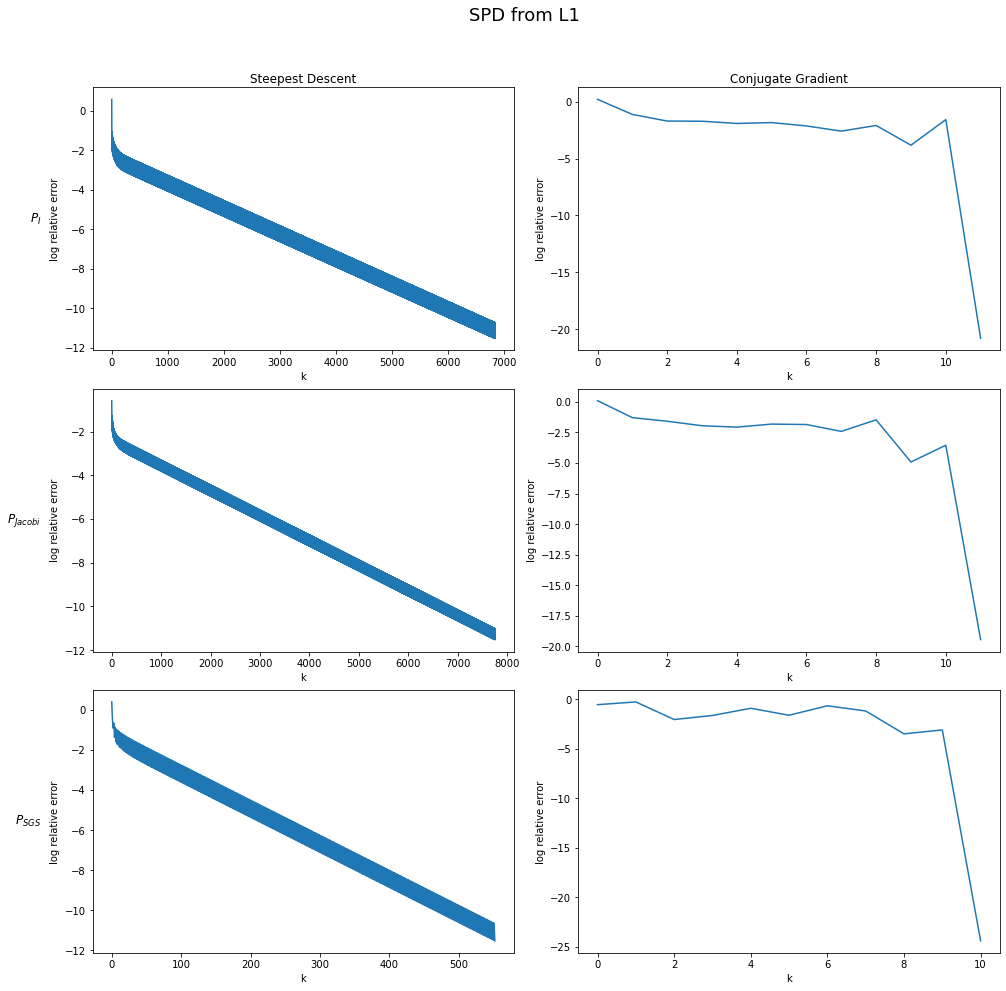

In [26]:
cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['$P_{I}$', '$P_{Jacobi}$', '$P_{SGS}$']]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 14))
plt.setp(axes.flat, xlabel='k', ylabel='log relative error')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].plot(np.log(PSDrand_none[1]))
axes[1][0].plot(np.log(PSDrand_Jacobi[1]))
axes[2][0].plot(np.log(PSDrand_SGS[1]))

#plot the conjugate gradient errors
axes[0][1].plot(np.log(PCGrand_none[1]))
axes[1][1].plot(np.log(PCGrand_Jacobi[1]))
axes[2][1].plot(np.log(PCGrand_SGS[1]))


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("SPD from L1", fontsize = 18, x = 0.55)

plt.savefig("..//figures/Log SPD L1 Errors")
plt.show()

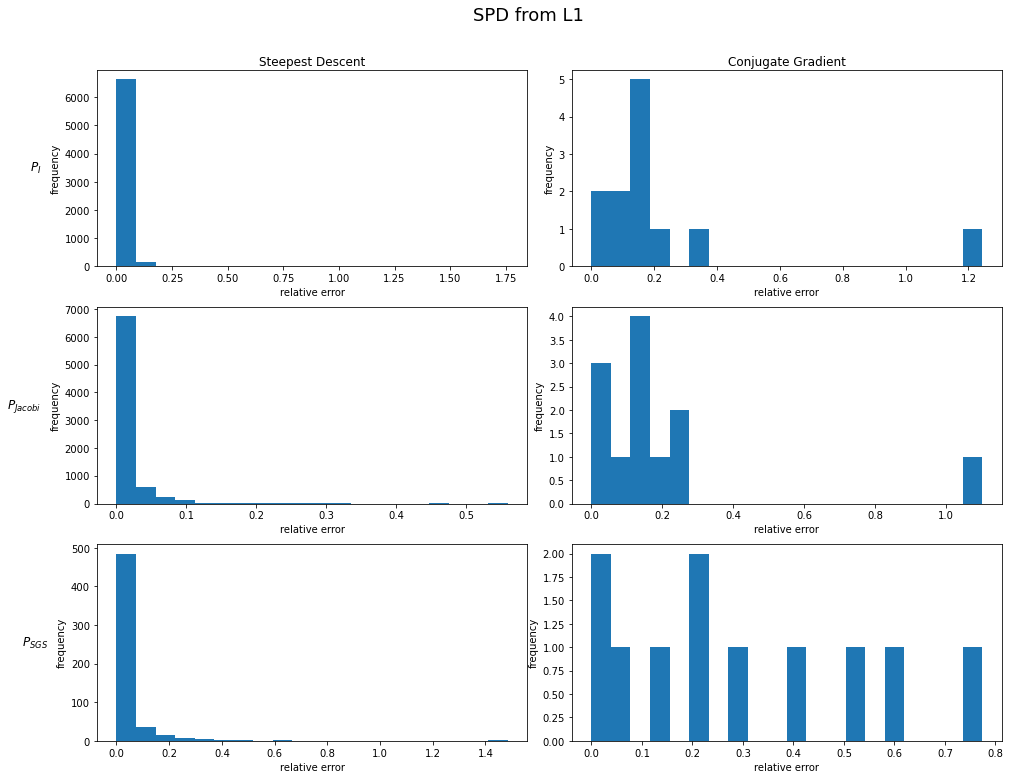

In [27]:
#Below plotting code taken from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
#in order to get row and column headers

cols = ['{}'.format(col) for col in ['Steepest Descent', 'Conjugate Gradient']]
rows = ['{}'.format(row) for row in ['$P_{I}$', '$P_{Jacobi}$', '$P_{SGS}$']]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 11))
plt.setp(axes.flat, xlabel='relative error', ylabel='frequency')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#plot the steepest descent errors
axes[0][0].hist(PSDrand_none[1], 20)
axes[1][0].hist(PSDrand_Jacobi[1], 20)
axes[2][0].hist(PSDrand_SGS[1], 20)

#plot the conjugate gradient errors
axes[0][1].hist(PCGrand_none[1], 20)
axes[1][1].hist(PCGrand_Jacobi[1], 20)
axes[2][1].hist(PCGrand_SGS[1], 20)


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.90)
plt.suptitle("SPD from L1", fontsize = 18, x = 0.55)

plt.savefig("..//figures/SPD L1 Histogram")
plt.show()

In [28]:
print("PSD x-values")
print(PSDTest_none[0])
print(PSDTest_Jacobi[0])
print(PSDTest_SGS[0])

print("PCG x-values")
print(PCGTest_none[0])
print(PCGTest_Jacobi[0])
print(PCGTest_SGS[0])

[1.04024002 0.97568755 0.98988699 1.00598863]
[0.9588438  1.02488461 1.01036462 0.99383009]
[1.04089809 0.97533971 0.98966799 1.006097  ]
PCG x-values
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
